# Intensity Graded FFT Animation with RTLSDR

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from IPython.display import HTML, Image

In [1]:
#Test capture
from rtlsdr import RtlSdr
sdr = RtlSdr()

# configure device
sdr.sample_rate = 2.048e6  # Hz
sdr.center_freq = 915e6     # Hz
sdr.gain = 'auto'
samples = sdr.read_samples(256*10240)
sdr.close()

In [1]:
#Function
def fft_intensity_animate(samples: np.ndarray, fft_len: int = 256, fft_div: int = 2, mag_steps: int = 100):
    
    num_ffts = math.floor(len(samples)/fft_len)
    
    fft_array = []
    for i in range(num_ffts):
        temp = np.fft.fftshift(np.fft.fft(samples[i*fft_len:(i+1)*fft_len]))
        temp_mag = 20.0 * np.log10(np.abs(temp))
        fft_array.append(temp_mag)
        
    max_mag = np.amax(fft_array)
    min_mag = np.abs(np.amin(fft_array))
    
    norm_fft_array = fft_array
    for i in range(num_ffts):
        norm_fft_array[i] = (fft_array[i]+min_mag)/(max_mag+min_mag) 
        
    return(norm_fft_array)

# Animation

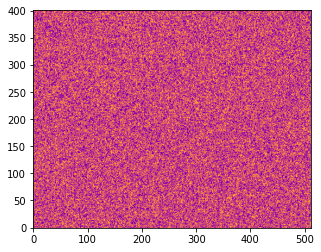

In [3]:
#Setup Animation data

#parameters
fft_len = 1024
fft_div = 2
mag_steps = 400

#animation place holder
fig = plt.figure()
zeros = np.zeros((mag_steps+1, int(fft_len/fft_div)), dtype=int)
a = np.random.random((mag_steps+1,int(fft_len/fft_div)))
im = plt.imshow(a, origin='lower', cmap='plasma', interpolation='bilinear')

#compute ffts for display
norm_fft_array = fft_intensity_animate(samples, fft_len, fft_div, mag_steps)

In [8]:
#Run Animation

#anumation init function
def init():
    zeros = np.zeros((mag_steps+1, int(fft_len/fft_div)), dtype=int)
    a = zeros
    im.set_data(np.random.random((mag_steps+1,int(fft_len/fft_div))))
    return[im]

#animate function that interates over fft data
def animate(i): 
    mag_step = 1/mag_steps
    
    if i == 0:
        hitmap_array = im.get_array()*np.exp(-10)
        
    else:
        hitmap_array = im.get_array()*np.exp(-0.04)

    for m in range(fft_len):
        hit_mag = int(norm_fft_array[i][m]/mag_step)
        hitmap_array[hit_mag][int(m/fft_div)] = hitmap_array[hit_mag][int(m/fft_div)] + .5

    #hitmap_array_db = 10.0 * np.log10(hitmap_array) 
    
    im.set_array(hitmap_array)
    return [im]

#compute animation
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)

# Save Animation

In [9]:
anim.save('fft_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

## Optional GIF Animation

In [6]:
#anim.save('fft_animation.gif', fps=30, writer='pillow')
#Image(url='fft_animation.gif')